In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, ridge_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import shap
from shap import explainers
import ipywidgets as widgets
from ipywidgets import interact

# Load and preprocess

In [2]:
def merge_location(df):
    print(df['CountryName'], df['RegionName'])
    country = df['CountryName'].iloc[0]
    region = df['RegionName'].iloc[0]
    area = '-'.join(filter(None, [country, region]))
    df['Area'] = area
    return df

LOG_COLS = ['H5_Investment in vaccines', 'Population', 'PopulationDensity']

data = pd.read_csv('../data/estims_all.csv', dtype={'RegionName':str})
n_country = len(data['CountryName'].unique())
data = data[pd.isna(data['RegionName'])] # remove regions since they do not have population data
data[LOG_COLS] = np.log(1 + data[LOG_COLS])
# data.fillna({'RegionName': ''}, inplace=True)
# data = data.groupby(['CountryName', 'RegionName']).apply(merge_location)
data.drop(columns=['R_var', 'Q0.025', 'Q0.5', 'Q0.975', 'cases', 'Date', 'RegionName', 'Jurisdiction'], inplace=True)

In [3]:
LABEL_COLS = ['R_mean']
FEAT_COLS = ['C1_Flag', 'C1_School closing', 'C2_Flag', 'C2_Workplace closing', 'C3_Cancel public events', 
             'C3_Flag', 'C4_Flag', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C5_Flag', 
             'C6_Flag', 'C6_Stay at home requirements', 'C7_Flag', 'C7_Restrictions on internal movement', 
             'C8_International travel controls', 'E1_Flag', 'E1_Income support', 'E2_Debt/contract relief', 
             'H1_Flag', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 
             'H5_Investment in vaccines', 'H6_Facial Coverings', 'H6_Flag', 'H7_Flag', 'H7_Vaccination policy', 
             'H8_Flag', 'H8_Protection of elderly people', 'Population', 'PopulationDensity', 
             'V1_Vaccine Prioritisation (summary)', 'V2A_Vaccine Availability (summary)', 
             'V2B_Vaccine age eligibility/availability age floor (general population summary)', 
             'V2C_Vaccine age eligibility/availability age floor (at risk summary)', 
             'V2D_Medically/ clinically vulnerable (Non-elderly)', 'V2E_Education', 
             'V2F_Frontline workers  (non healthcare)', 'V2G_Frontline workers  (healthcare)', 
             'V3_Vaccine Financial Support (summary)', 'V4_Mandatory Vaccination (summary)',
             'CountryName']

def shift(df, shift=14):
    feats = df[FEAT_COLS]
    labels = df[LABEL_COLS].shift(-shift).iloc[:-shift]
    return feats.merge(labels, how='inner', left_index=True, right_index=True)

data = data.groupby('CountryName', group_keys=False).apply(shift).reset_index(drop=True)

In [4]:
# data.drop(columns=['CountryName'], inplace=True)
y = pd.get_dummies(data['CountryName'], prefix='Country')
areas = data['CountryName']
data = data.drop(columns=['CountryName']).merge(y, left_index=True, right_index=True, how='inner')

# Train to predict ConfirmedCases

In [5]:
Y = data['R_mean']
X = data.drop(columns=['R_mean'])

In [6]:
scaler = MinMaxScaler()
# model = LinearRegression()
model = RandomForestRegressor(n_estimators=10)

In [73]:
scores = []

kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
for train_idx, val_idx in tqdm(kfold.split(X.index, areas)):
    train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = Y.iloc[train_idx], Y.iloc[val_idx]
    train_x = scaler.fit_transform(train_x)
    val_x = scaler.transform(val_x)
    
    model.fit(train_x, train_y)
    score = model.score(val_x, val_y)
    scores.append(score)
    
print(scores)
print(np.mean(scores))

5it [01:00, 12.14s/it]

[-0.19758239357197294, -0.8436701025261715, -0.33795507800797364, -0.1982666111847644, -1.2356287421918415]
-0.5626205854965448


# Result

+ random forest (shuffle): [0.780965544486699, 0.7885151695642806, 0.8012048453095675, 0.7907898000552722, 0.7953448227960056] => 0.791364036442365
+ random forest (no shuffle): [-0.18571328679546184, -0.927070106311638, -0.16726759522169976, 0.021319901072995084, -0.9997124714349126] => -0.4516887117381434

# SHAP values

In [7]:
train_x = scaler.fit_transform(X)
model.fit(train_x, Y)

RandomForestRegressor(n_estimators=10)

In [8]:
explainer = explainers.Tree(model, model_output='raw')
# print the JS visualization code to the notebook
shap.initjs()

In [9]:
np.random.seed(1337)
idxs = np.random.randint(0,len(train_x)-1, n_country * 50)
shap_values = explainer.shap_values(train_x[idxs])

In [10]:
np.save('shap_values.npy', shap_values)
np.save('idxs.npy', idxs)

In [11]:
shap_values = np.load('shap_values.npy')

In [34]:
# inspect each sample
def plot(idx):
    shap_value_single = explainer.shap_values(train_x[idx])

    shap.force_plot(base_value = explainer.expected_value,
                    shap_values = shap_value_single,
                    features = X.columns,
                    matplotlib=True)
    
interact(plot, idx=(0,len(X)-1))

interactive(children=(IntSlider(value=71409, description='idx', max=142819), Output()), _dom_classes=('widget-…

<function __main__.plot(idx)>

## Plot only NPI features

In [14]:
npis = list(filter(lambda x: 'Country' not in x, X.columns))
print(npis)
npi_idxs = [X.columns.get_loc(c) for c in npis]

['C1_Flag', 'C1_School closing', 'C2_Flag', 'C2_Workplace closing', 'C3_Cancel public events', 'C3_Flag', 'C4_Flag', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C5_Flag', 'C6_Flag', 'C6_Stay at home requirements', 'C7_Flag', 'C7_Restrictions on internal movement', 'C8_International travel controls', 'E1_Flag', 'E1_Income support', 'E2_Debt/contract relief', 'H1_Flag', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 'H5_Investment in vaccines', 'H6_Facial Coverings', 'H6_Flag', 'H7_Flag', 'H7_Vaccination policy', 'H8_Flag', 'H8_Protection of elderly people', 'Population', 'PopulationDensity', 'V1_Vaccine Prioritisation (summary)', 'V2A_Vaccine Availability (summary)', 'V2B_Vaccine age eligibility/availability age floor (general population summary)', 'V2C_Vaccine age eligibility/availability age floor (at risk summary)', 'V2D_Medically/ clinically vulnerable (Non-elderly)', 'V2E_Education', 'V2F_Frontline workers  (non healthcare)', 'V2G_F

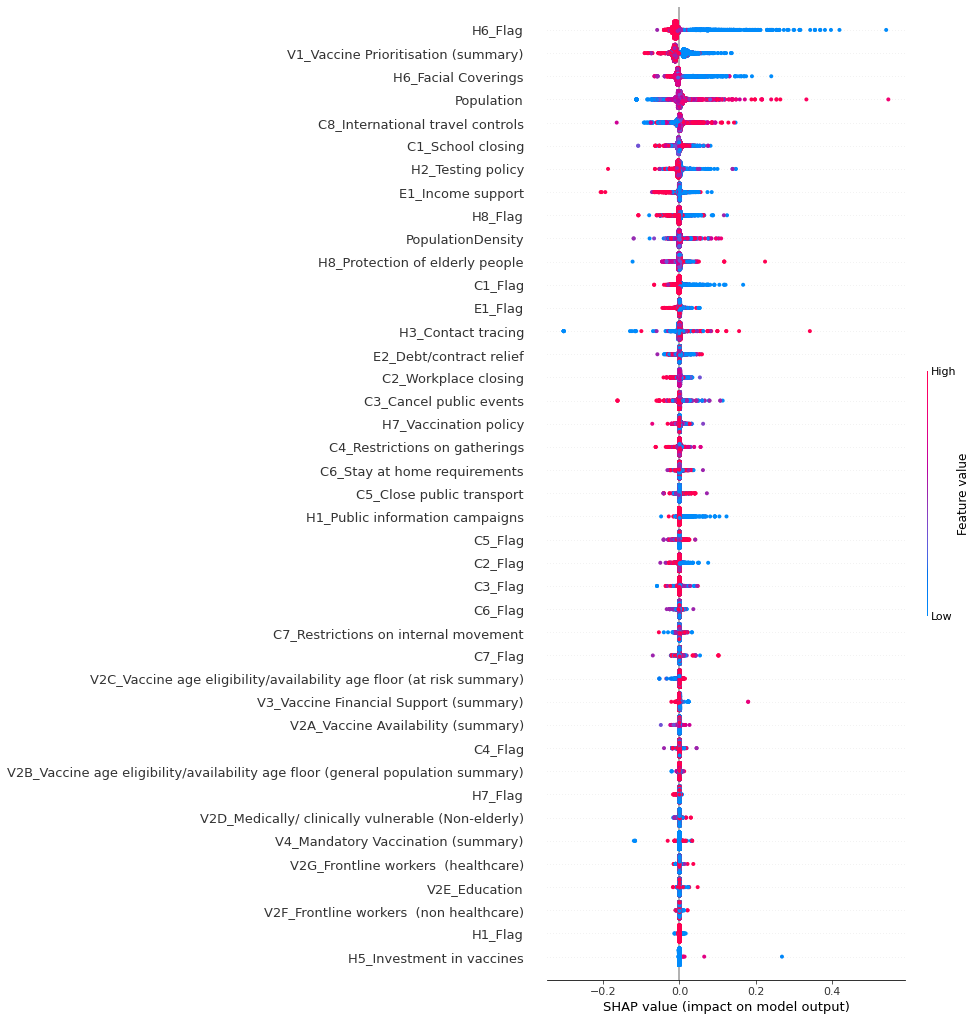

In [15]:
shap.summary_plot(shap_values = shap_values[:,npi_idxs],
                  features = X.iloc[idxs,npi_idxs],
                  max_display=len(npis),
                  plot_type='dot',
                  show=False
                 )
plt.savefig('figs/shap_fdot.jpg', bbox_inches='tight', dpi=128)

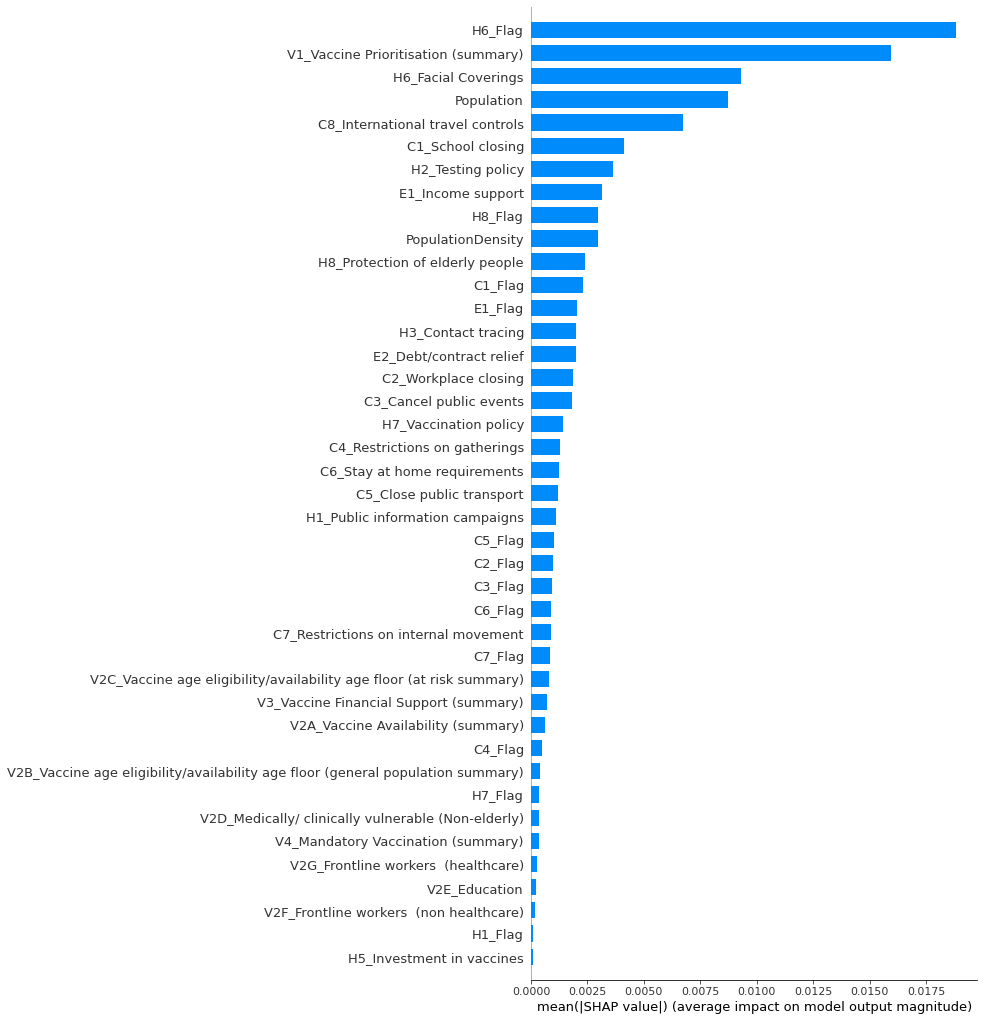

In [16]:
shap.summary_plot(shap_values = shap_values[:,npi_idxs],
                  features = X.iloc[idxs,npi_idxs],
                  max_display=len(npis),
                  plot_type='bar',
                  show=False
                 )
plt.savefig('figs/shap_fbar.jpg', bbox_inches='tight', dpi=128)

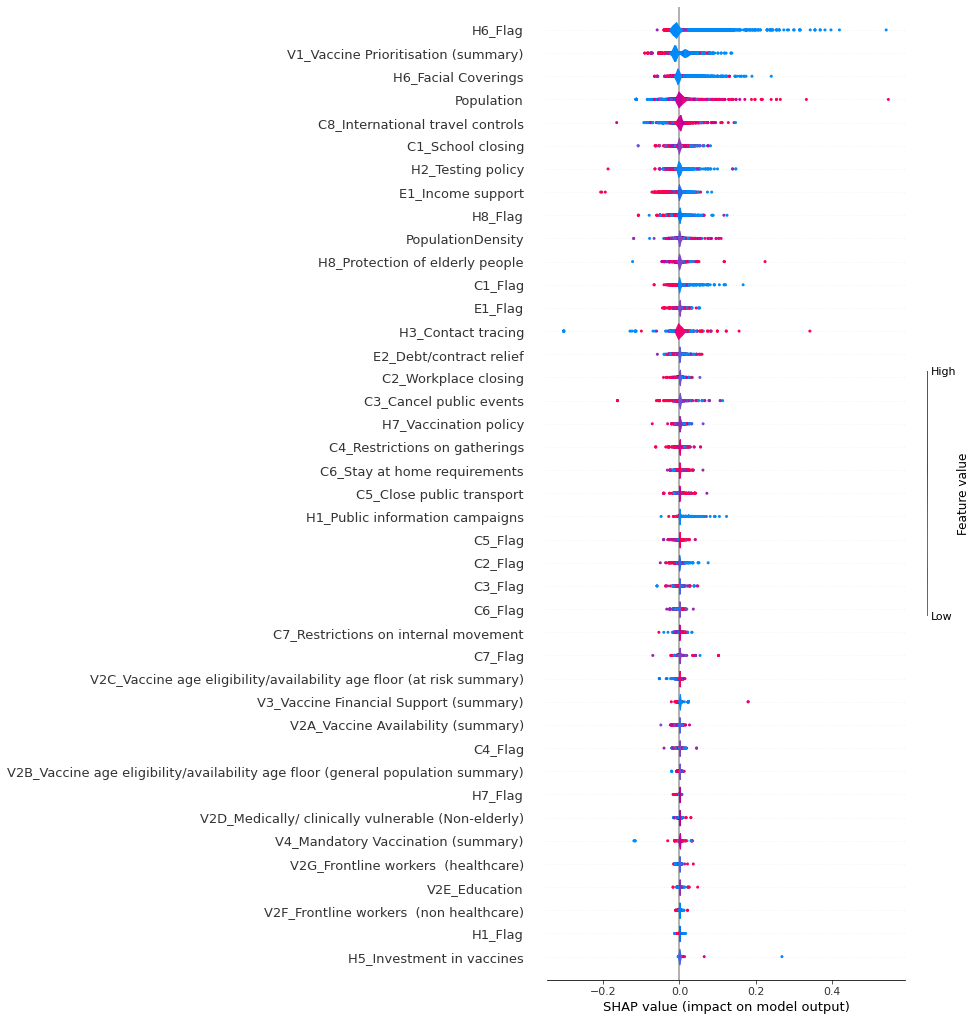

In [23]:
shap.summary_plot(shap_values = shap_values[:,npi_idxs],
                  features = X.iloc[idxs,npi_idxs],
                  max_display=len(npis),
                  plot_type='violin',
                  show=False
                 )
plt.savefig('figs/shap_fviolin.jpg', bbox_inches='tight', dpi=128)

## Plot for country Features

In [18]:
countries = list(filter(lambda x: 'Country' in x, X.columns))
print(countries)
country_idxs = [X.columns.get_loc(c) for c in countries]

['Country_Afghanistan', 'Country_Albania', 'Country_Algeria', 'Country_Andorra', 'Country_Angola', 'Country_Argentina', 'Country_Aruba', 'Country_Australia', 'Country_Austria', 'Country_Azerbaijan', 'Country_Bahamas', 'Country_Bahrain', 'Country_Bangladesh', 'Country_Barbados', 'Country_Belarus', 'Country_Belgium', 'Country_Belize', 'Country_Benin', 'Country_Bermuda', 'Country_Bhutan', 'Country_Bolivia', 'Country_Bosnia and Herzegovina', 'Country_Botswana', 'Country_Brazil', 'Country_Brunei', 'Country_Bulgaria', 'Country_Burkina Faso', 'Country_Burundi', 'Country_Cambodia', 'Country_Cameroon', 'Country_Canada', 'Country_Cape Verde', 'Country_Central African Republic', 'Country_Chad', 'Country_Chile', 'Country_China', 'Country_Colombia', 'Country_Comoros', 'Country_Congo', 'Country_Costa Rica', "Country_Cote d'Ivoire", 'Country_Croatia', 'Country_Cuba', 'Country_Cyprus', 'Country_Czech Republic', 'Country_Democratic Republic of Congo', 'Country_Denmark', 'Country_Djibouti', 'Country_Dom

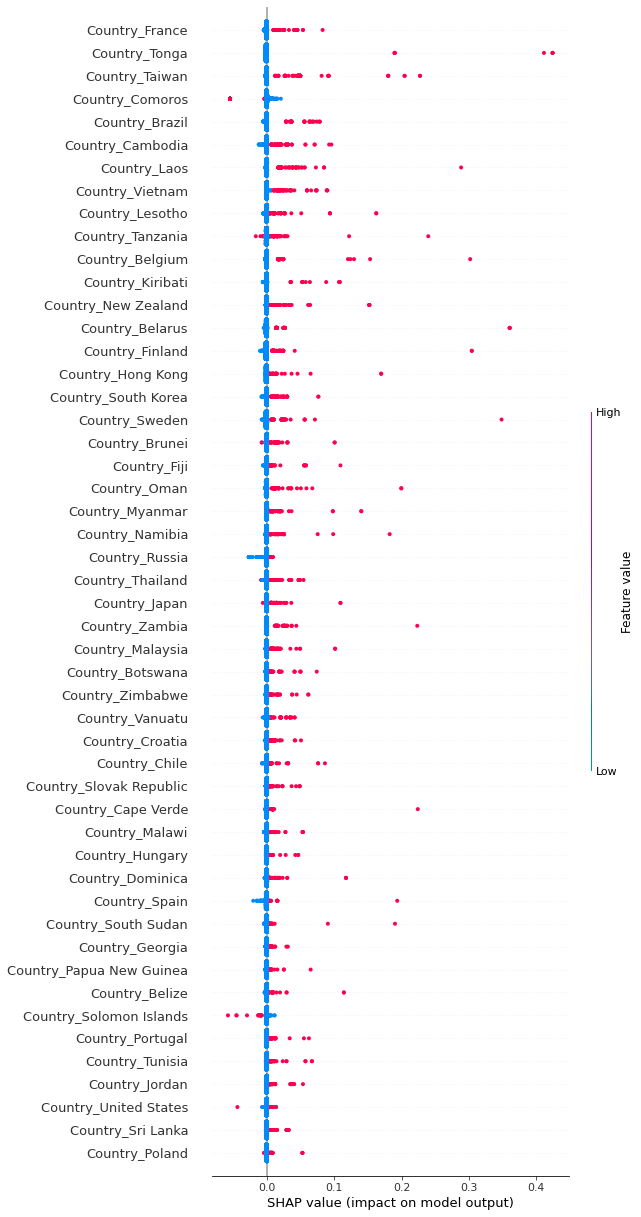

In [19]:
shap.summary_plot(shap_values = shap_values[:,country_idxs],
                  features = X.iloc[idxs,country_idxs],
                  max_display=50,
                  plot_type='dot',
                  show=False
                 )
plt.savefig('figs/shap_cdot.jpg', bbox_inches='tight', dpi=128)

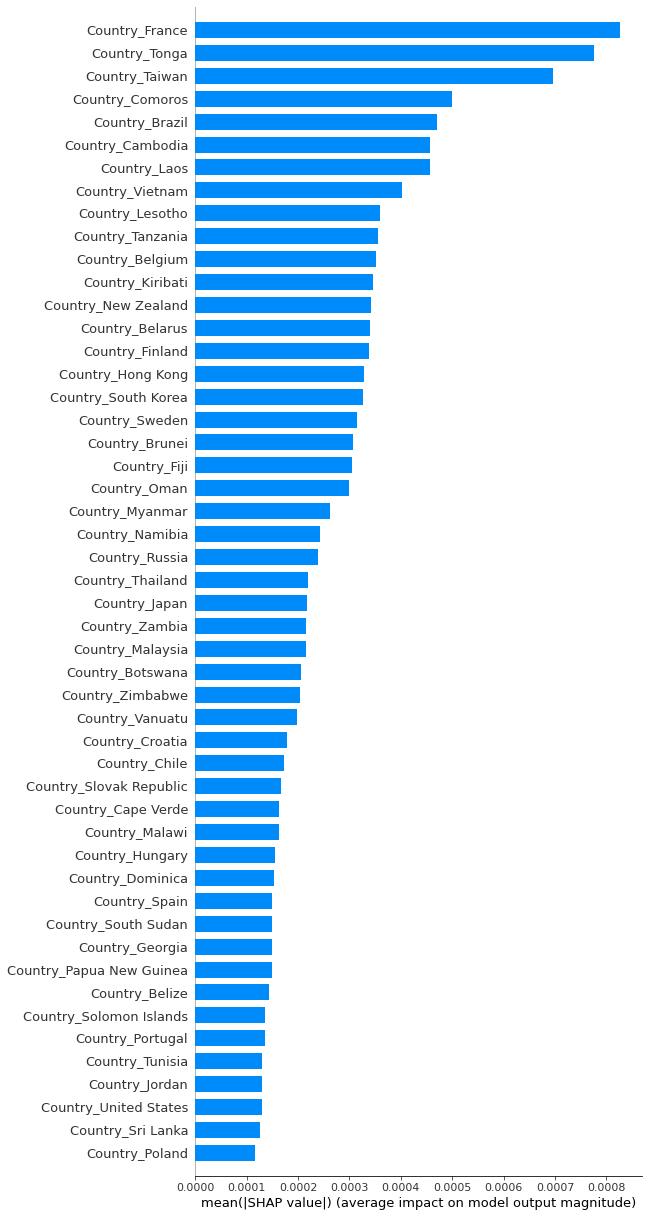

In [20]:
shap.summary_plot(shap_values = shap_values[:,country_idxs],
                  features = X.iloc[idxs,country_idxs],
                  max_display=50,
                  plot_type='bar',
                  show=False
                 )
plt.savefig('figs/shap_cbar.jpg', bbox_inches='tight', dpi=128)

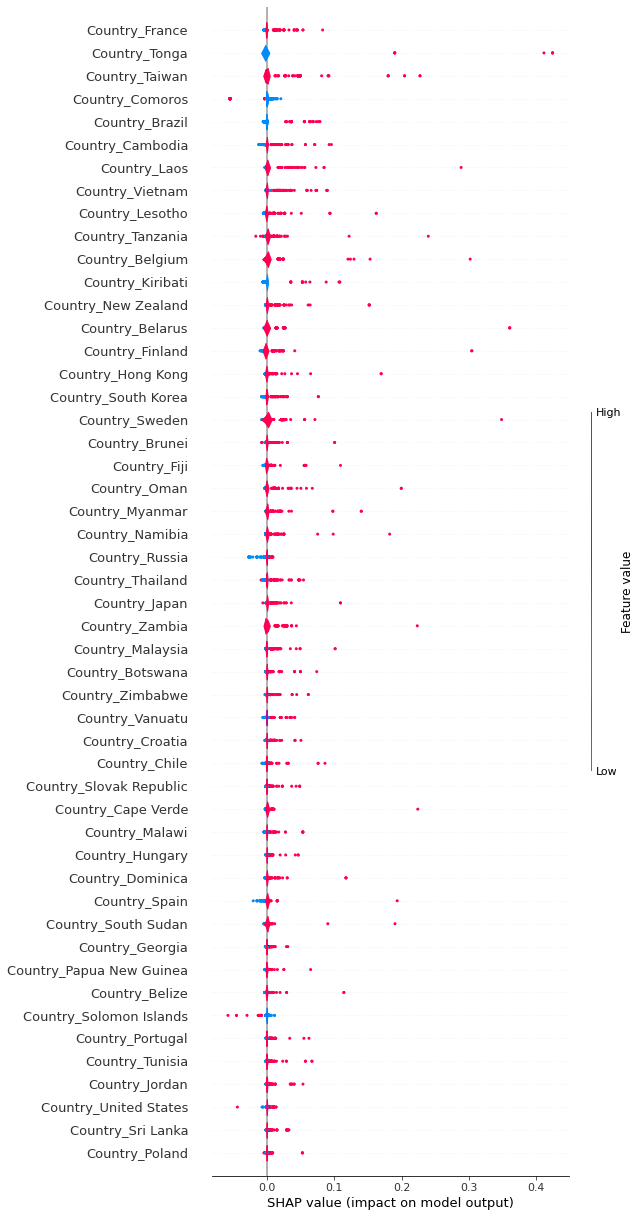

In [22]:
shap.summary_plot(shap_values = shap_values[:,country_idxs],
                  features = X.iloc[idxs,country_idxs],
                  max_display=50,
                  plot_type='violin',
                  show=False
                 )
plt.savefig('figs/shap_cviolin.jpg', bbox_inches='tight', dpi=128)

## Plot all features (including countries)

In [12]:
# print the JS visualization code to the notebook
shap.initjs()
shap.summary_plot(shap_values = shap_values,
                  features = X.iloc[idxs,:],
                  max_display=50,
                  plot_type='dot',
                  show=False
                 )
f = plt.gcf()
plt.savefig('figs/shap_dot.jpg', bbox_inches='tight', dpi=128)

NameError: name 'idxs' is not defined

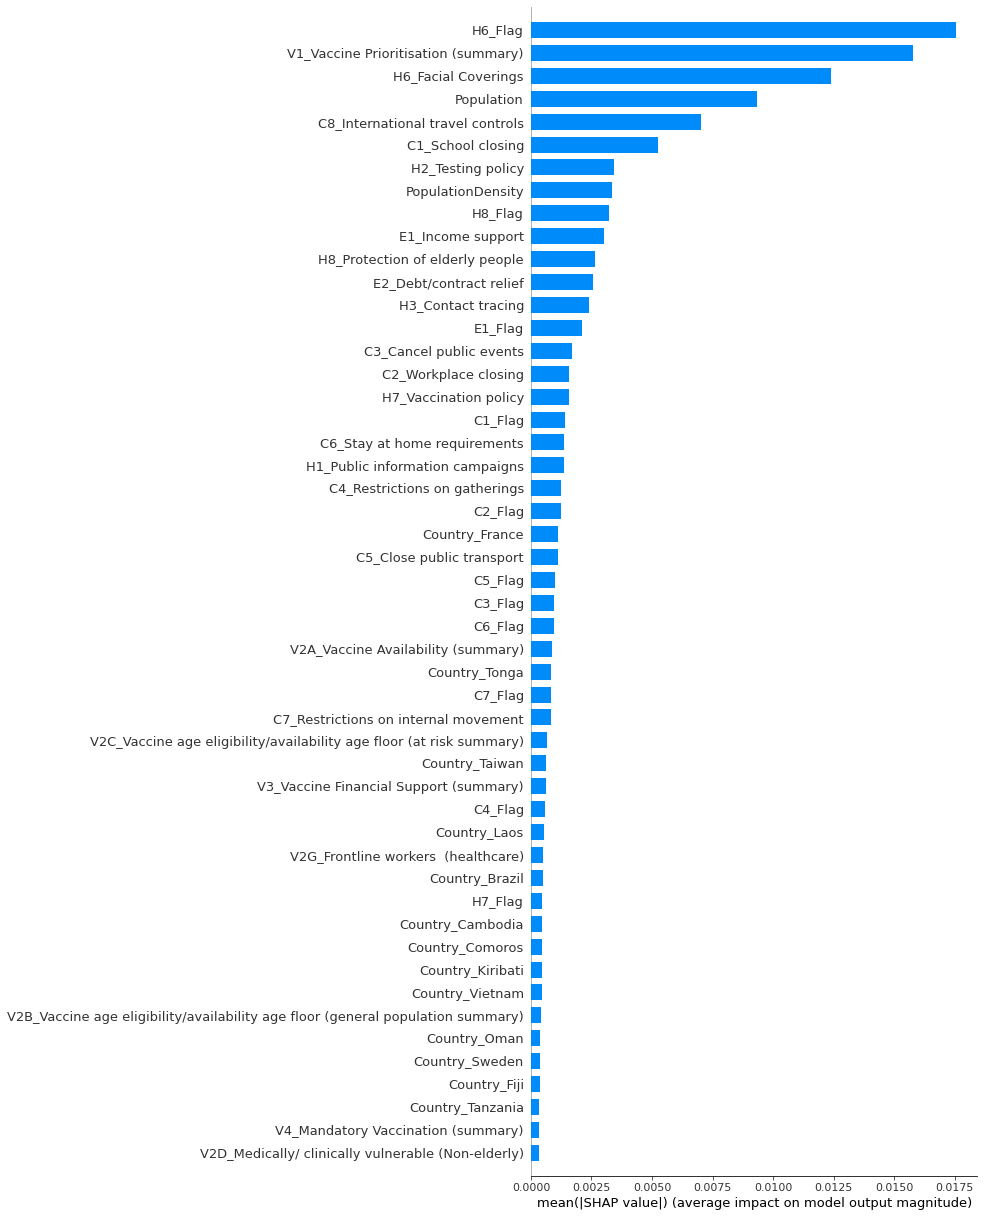

<Figure size 432x288 with 0 Axes>

In [39]:
shap.summary_plot(shap_values = shap_values,
                  features = X.iloc[idxs,:],
                  max_display=50,
                  plot_type='bar'
                 )
plt.savefig('figs/shap_bar.jpg', bbox_inches='tight', dpi=128)

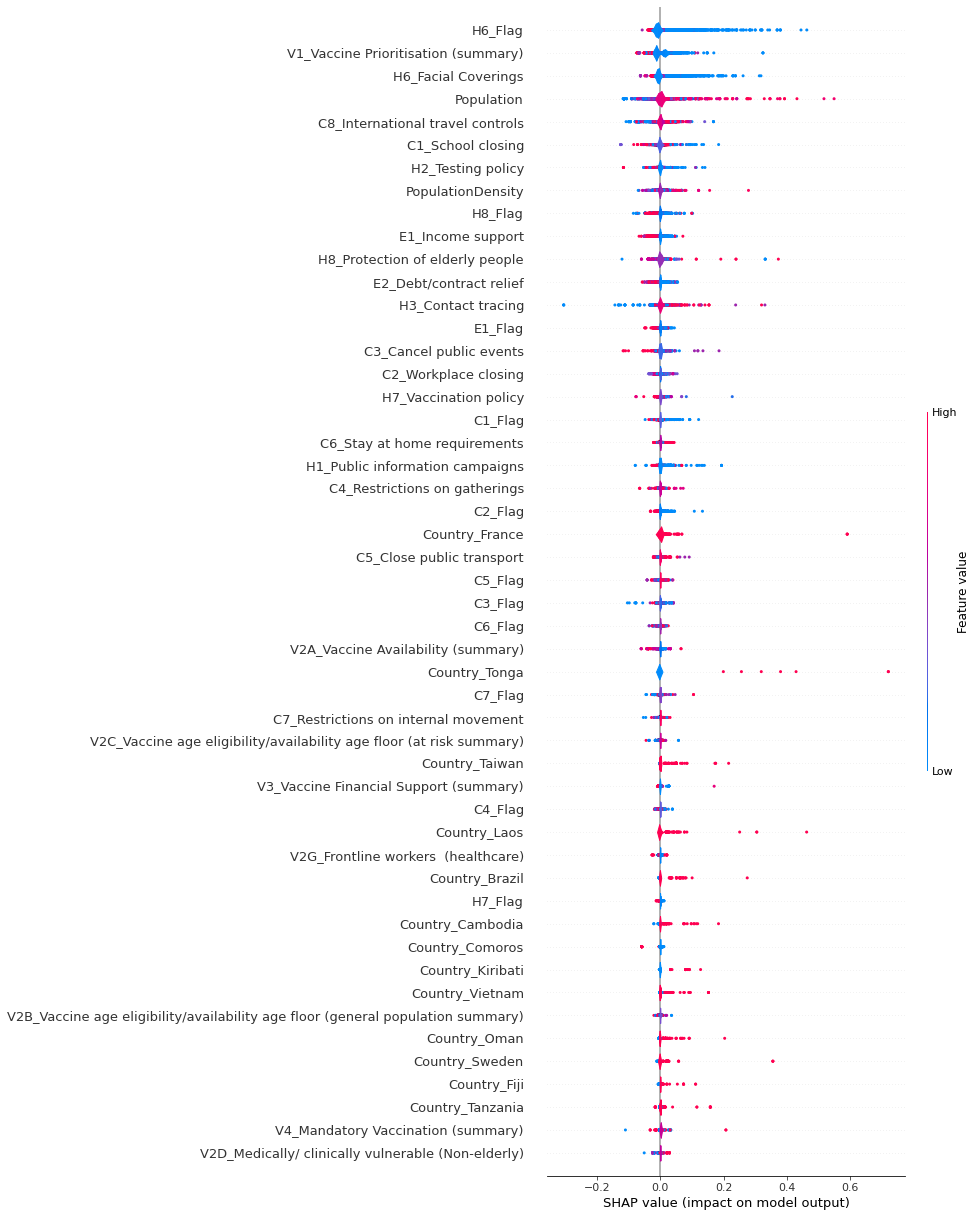

<Figure size 432x288 with 0 Axes>

In [40]:
shap.summary_plot(shap_values = shap_values,
                  features = X.iloc[idxs,:],
                  max_display=50,
                  plot_type='violin'
                 )
plt.savefig('figs/shap_violon.jpg', bbox_inches='tight', dpi=128)

# Inspect data distribution

In [65]:
def plot(col, logx=False, logy=False):
    if logx:
        x = np.log(1+data[col])
    else:
        x = data[col]
    plt.hist(x)
    if logy:
        plt.yscale('log')

interact(plot, col=data.columns)

interactive(children=(Dropdown(description='col', options=('CountryName', 'C1_School closing', 'C1_Flag', 'C2_…

<function __main__.plot(col, logx=False, logy=False)>